# Company Bankruptcy Prediction - etap 3 - modelowanie i walidacja

## Plan projektu:
- 1. Import potrzebnych pakietów
- 2. Wczytanie danych
- 3. Analiza działania modeli:
    - 3.1. Regresja logistyczna
    - 3.2. Decision tree classifier (Drzewa decyzyjne)
        - 3.2.1. GINI
        - 3.2.2. Entropy
    - 3.3. Random forest classifier (Las losowy)
    - 3.4. C-Support Vector Classification
    - 3.5. Gradient boosting classifier
    - 3.6. Naive Bayes
    - 3.7. KNN
- 4. Podsumowanie działania modeli
- 5. Wykresy dodatkowe (do prezentacji)
- 6. Dodatkowy test dla Logistic Regression
- 7. Wnioski


## 1. Import potrzebnych pakietów

In [105]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import shap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
# from sklearn import feature_selection
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, roc_auc_score
# from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from matplotlib.colors import LinearSegmentedColormap

shap.initjs()


# from deap import base, creator, tools, algorithms
# from scipy import stats



## 2. Wczytanie danych

W wyniku Feature Engineering oraz Feature Selection otrzymałyśmy po dwa zestawy danych: zawierające odpowiednio po 13 i 27 zmiennych. Przetestujemy, który zbiór danych będzie miał lepsze wyniki dla modelu Logistic Regression (zbadamy wartość wskaźnika f1 score) i to na nim później będziemy pracować.

### 2.1. Dane treningowe

Wczytujemy zbiory danych treningowych:

In [6]:
df = pd.read_csv('train_after_fe_13.csv')
df = df[df.columns[1:]]
df.columns = [i.strip() for i in df.columns]
Y_train13 = df[df.columns[0]]
X_train13 = df[df.columns[1:]]

In [7]:
df = pd.read_csv('train_after_fe_27.csv')
df = df[df.columns[1:]]
df.columns = [i.strip() for i in df.columns]
Y_train27 = df[df.columns[0]]
X_train27 = df[df.columns[1:]]

### 2.2. Dane testowe
Wczytujemy zbiory danych testowych:

In [8]:
df = pd.read_csv('test_after_fe_13.csv')
df = df[df.columns[1:]]
df.columns = [i.strip() for i in df.columns]
Y_test13 = df[df.columns[0]]
X_test13 = df[df.columns[1:]]

In [9]:
df = pd.read_csv('test_after_fe_27.csv')
df = df[df.columns[1:]]
df.columns = [i.strip() for i in df.columns]
Y_test27 = df[df.columns[0]]
X_test27 = df[df.columns[1:]]

## 3. Analiza działania modeli:

### 3.1. Regresja logistyczna

#### 3.1.1. Dane z 13 cechami

Najpierw definiujemy model regresji logistycznej z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [6]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train13, Y_train13)

LogisticRegression()

Sprawdzamy, jak model przewidzi responder dla danych testowych (w celu zbadania, który zbiór danych jest lepszy, sprawdzamy też wynik dla danych treningowych):

In [7]:
Y_pred_lr_train = clf_lr.predict(X_train13)

In [8]:
Y_pred_lr_test = clf_lr.predict(X_test13)

Sprawdzamy wskaźniki f1 score:

In [9]:
f1_lr_train = f1_score(Y_train13, Y_pred_lr_train, average="weighted")
print("F1 score - train:", f1_lr_train)

F1 score - train: 0.9545036117374286


In [10]:
f1_lr_test = f1_score(Y_test13, Y_pred_lr_test, average="weighted")
print("F1 score - test:", f1_lr_test)


F1 score - test: 0.9605687091720613


#### 3.1.2. Dane z 27 cechami

Teraz wykonamy analogiczne kroki jak wyżej dla danych z 27 cechami:

In [11]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train27, Y_train27)

LogisticRegression()

In [12]:
Y_pred_lr_train = clf_lr.predict(X_train27)

In [13]:
Y_pred_lr_test = clf_lr.predict(X_test27)

In [14]:
f1_lr_train = f1_score(Y_train27, Y_pred_lr_train, average="weighted")
print("F1 score - train:", f1_lr_train)

F1 score - train: 0.9597870969123353


In [15]:
f1_lr_test = f1_score(Y_test27, Y_pred_lr_test, average="weighted")
print("F1 score - test:", f1_lr_test)

F1 score - test: 0.9666912494927249


Możemy zauważyć, że dane z 27 cechami już teraz osiągają lepsze wyniki. W związku z tym to na nich będziemy pracować w dalszej części projektu. Dla wygody zapiszmy je pod innymi nazwami.

In [10]:
X_train = X_train27
Y_train = Y_train27
X_test = X_test27
Y_test = Y_test27

Przypomnijmy wynik f1 score oraz sprawdźmy jeszcze wskaźnik ROC-AUC dla modelu regresji logistycznej dla wybranych danych:

In [17]:
print("Logistic regression - f1 score:", f1_lr_test)

Logistic regression - f1 score: 0.9666912494927249


In [18]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_lr = clf_lr.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_lr = roc_auc_score(Y_test, Y_prob_lr)

print("Logistic regression - ROC-AUC score:", roc_auc_lr)


Logistic regression - ROC-AUC score: 0.9410671389244446


Teraz zajmiemy się dostrojeniem parametrów. Wykorzystamy technikę Grid Search:

In [19]:
# Definicja modelu
clf_lr = LogisticRegression()

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_lr, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Najlepsze parametry: {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
180 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solve

Wytrenujmy model z dobranymi najlepszymi parametrami:

In [11]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
clf_lr = LogisticRegression(penalty='l2',  C=10.0, solver='newton-cg', max_iter=100)
clf_lr.fit(X_train, Y_train)

LogisticRegression(C=10.0, solver='newton-cg')

Po raz kolejny sprawdźmy, jak model przewidzi responder dla danych testowych:

In [18]:
Y_pred_lr = clf_lr.predict(X_test)

Ponownie sprawdźmy wskaźniki f1 score oraz ROC-AUC:

In [19]:
f1_lr = f1_score(Y_test, Y_pred_lr, average="weighted")
print("Logistic regression - f1 score:", f1_lr)

Logistic regression - f1 score: 0.964716635900633


In [20]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_lr = clf_lr.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_lr = roc_auc_score(Y_test, Y_prob_lr)

print("Logistic regression - ROC-AUC score:", roc_auc_lr)

Logistic regression - ROC-AUC score: 0.9410320702775683


Wykorzystamy pakiet SHAP, aby lepiej zrozumieć, które zmienne miały wpływ na model:

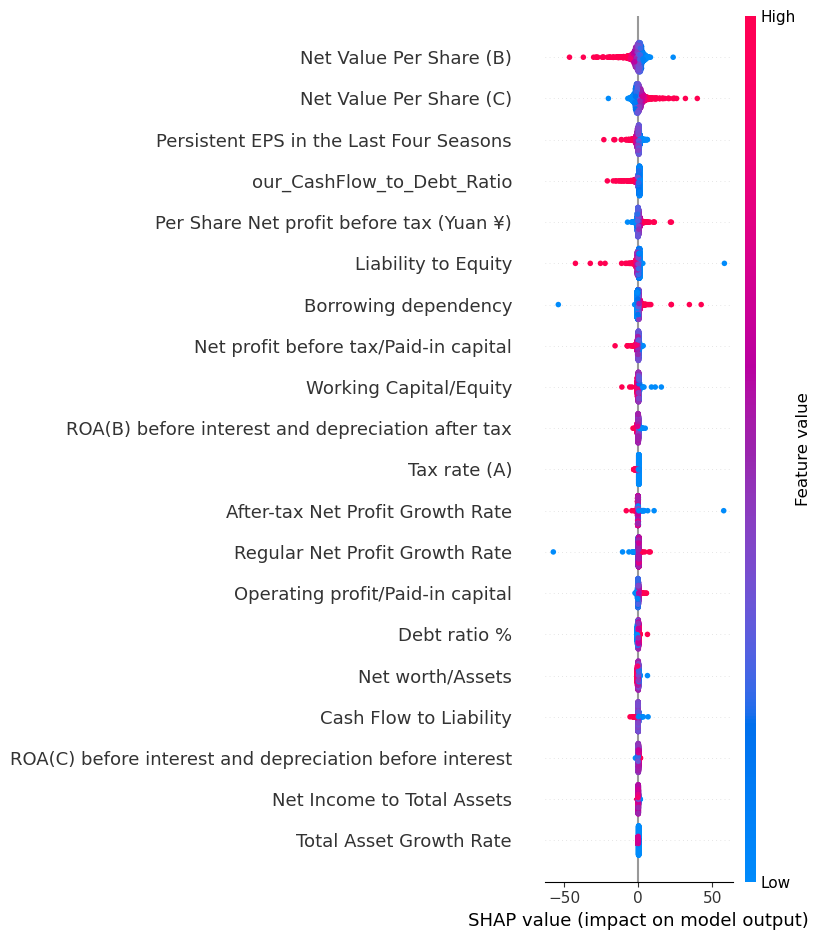

In [25]:
# Utwórz obiekt Explainer
explainer_lr = shap.Explainer(clf_lr, X_train)

# Oblicz wartości SHAP
shap_values_lr = explainer_lr.shap_values(X_test)

# Wygeneruj wykres podsumowujący
shap.summary_plot(shap_values_lr, X_test)

# Wyjaśnij pojedynczą predykcję
shap.force_plot(explainer_lr.expected_value, shap_values_lr[0], X_test.iloc[0, :])

### 3.2. Drzewa decyzyjne

3.2.1. GINI

Najpierw definiujemy model drzewa decyzyjnego z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [26]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10, random_state=0)
clf_dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

Sprawdzamy, jak model przewidzi responder dla danych testowych:

In [27]:
Y_pred_dt = clf_dt.predict(X_test)

Sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [28]:
f1_dt = f1_score(Y_test, Y_pred_dt, average="weighted")
print("Decision tree classifier (GINI) - f1 score:", f1_dt)

Decision tree classifier (GINI) - f1 score: 0.9534122766349735


In [29]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_dt = clf_dt.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_dt = roc_auc_score(Y_test, Y_prob_dt)

print("Decision tree classifier (GINI) - ROC-AUC score:", roc_auc_dt)


Decision tree classifier (GINI) - ROC-AUC score: 0.6741245989023513


Znowu przy użyciu techniki Grid Search zajmiemy się dostrojeniem parametrów:

In [30]:
# Definicja modelu
clf_dt = tree.DecisionTreeClassifier()

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_dt, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


Najlepsze parametry: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


Nauczmy model z wykorzystaniem najlepszych parametrów:

In [32]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
clf_dt = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5)
clf_dt.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5)

Znowu sprawdzamy, jak model przewidzi responder dla danych testowych:

In [32]:
Y_pred_dt = clf_dt.predict(X_test)

Ponownie sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [33]:
f1_dt = f1_score(Y_test, Y_pred_dt, average="weighted")
print("Decision tree classifier (GINI) - f1 score:", f1_dt)

Decision tree classifier (GINI) - f1 score: 0.9494702695316304


In [34]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_dt = clf_dt.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_dt = roc_auc_score(Y_test, Y_prob_dt)

print("Decision tree classifier (GINI) - ROC-AUC score:", roc_auc_dt)

Decision tree classifier (GINI) - ROC-AUC score: 0.6829969665620452


Sprawdźmy, co pokaże pakiet SHAP:

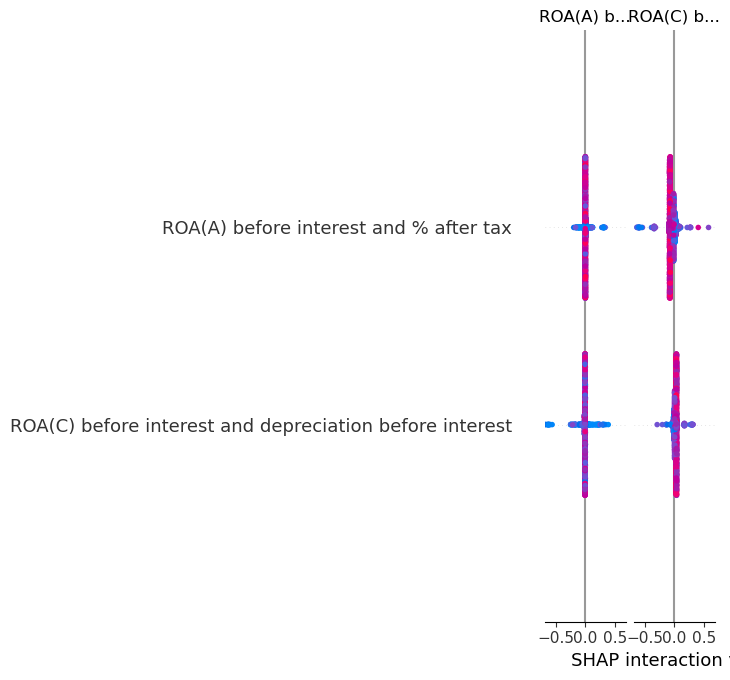

In [35]:
# Utwórz explainer SHAP dla modelu drzewa decyzyjnego
explainer_dt = shap.TreeExplainer(clf_dt)

# Wyjaśnij prognozy dla konkretnych przypadków testowych
shap_values_dt = explainer_dt.shap_values(X_test)

# Wizualizacja summary plot
shap.summary_plot(shap_values_dt, X_test)

#### 3.2.2. Entropy

Najpierw definiujemy model drzewa decyzyjnego z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [36]:
clf_dte = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10, random_state=0)
clf_dte.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)

Sprawdzamy, jak model przewidzi responder dla danych testowych:

In [37]:
Y_pred_dte = clf_dte.predict(X_test)

Sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [38]:
f1_dte = f1_score(Y_test, Y_pred_dte, average="weighted")
print("Decision tree classifier (Entropy) - f1 score:", f1_dte)

Decision tree classifier (Entropy) - f1 score: 0.9370198541853662


In [39]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_dte = clf_dte.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_dte = roc_auc_score(Y_test, Y_prob_dte)

print("Decision tree classifier (Entropy) - ROC-AUC score:", roc_auc_dte)


Decision tree classifier (Entropy) - ROC-AUC score: 0.7183987655836299


Dostroimy parametry także dla tego modelu. Użyjemy po raz kolejny techniki Grid Search, później ponownie nauczymy model, sprawdzimy przewidywania respondera dla danych testowych i obliczymy wskaźniki f1 oraz ROC-AUC:

In [40]:
# Definicja modelu
clf_dte = tree.DecisionTreeClassifier(criterion="entropy")

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_dte, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


Najlepsze parametry: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


Wytrenujmy model z dobranymi najlepszymi parametrami:

In [41]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
clf_dte = tree.DecisionTreeClassifier(criterion="entropy", max_depth=None, min_samples_leaf=1, min_samples_split=10)
clf_dte.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=10)

In [42]:
Y_pred_dte = clf_dte.predict(X_test)

In [43]:
f1_dte = f1_score(Y_test, Y_pred_dte, average="weighted")
print("Decision tree classifier (Entropy) - f1 score:", f1_dte)

Decision tree classifier (Entropy) - f1 score: 0.9349986835949589


In [44]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_dte = clf_dte.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_dte = roc_auc_score(Y_test, Y_prob_dte)

print("ROC-AUC score:", roc_auc_dte)

ROC-AUC score: 0.7040732233346777


Sprawdźmy, co pokaże pakiet SHAP:

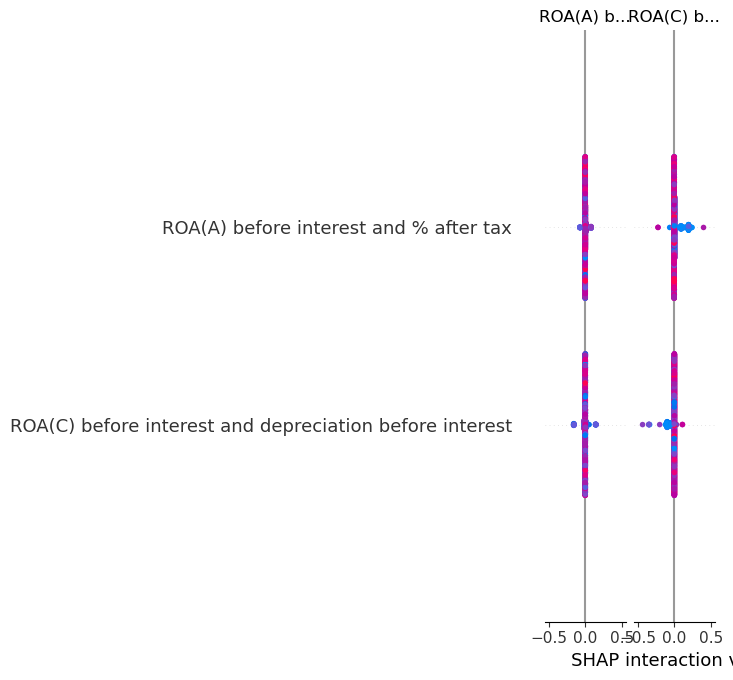

In [45]:
# Utwórz explainer SHAP dla modelu drzewa decyzyjnego
explainer_dte = shap.TreeExplainer(clf_dte)

# Wyjaśnij prognozy dla konkretnych przypadków testowych
shap_values_dte = explainer_dte.shap_values(X_test)

# Wizualizacja summary plot
shap.summary_plot(shap_values_dte, X_test)

### 3.3. Las losowy

Najpierw definiujemy model lasu losowego z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [46]:
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=0)

Sprawdzamy, jak model przewidzi responder dla danych testowych:

In [47]:
Y_pred_rf = clf_rf.predict(X_test)

Sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [48]:
f1_rf = f1_score(Y_test, Y_pred_rf, average="weighted")
print("Random forest classifier - f1 score:", f1_rf)

Random forest classifier - f1 score: 0.958963594861112


In [49]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_rf = roc_auc_score(Y_test, Y_prob_rf)

print("Random forest classifier - ROC-AUC score:", roc_auc_rf)

Random forest classifier - ROC-AUC score: 0.9337290245655872


Teraz dostrajanie parametrów i ponowne trenowanie modelu:

In [50]:
# Definicja modelu
clf_rf = RandomForestClassifier()

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_rf, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\pauli\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

Najlepsze parametry: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


Wytrenujmy model z dobranymi najlepszymi parametrami:

In [97]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
clf_rf = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=100)
clf_rf.fit(X_train, Y_train)

RandomForestClassifier(min_samples_split=5)

In [52]:
Y_pred_rf = clf_rf.predict(X_test)

In [53]:
f1_rf = f1_score(Y_test, Y_pred_rf, average="weighted")
print("Random Forest Classifier - f1 score:", f1_rf)

Random Forest Classifier - f1 score: 0.9628106240310031


In [54]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_rf = roc_auc_score(Y_test, Y_prob_rf)

print("Random Forest Classifier - ROC-AUC score:", roc_auc_rf)

Random Forest Classifier - ROC-AUC score: 0.9334221739054198


Spójrzmy na wyniki otrzymane przy użyciu pakietu SHAP:

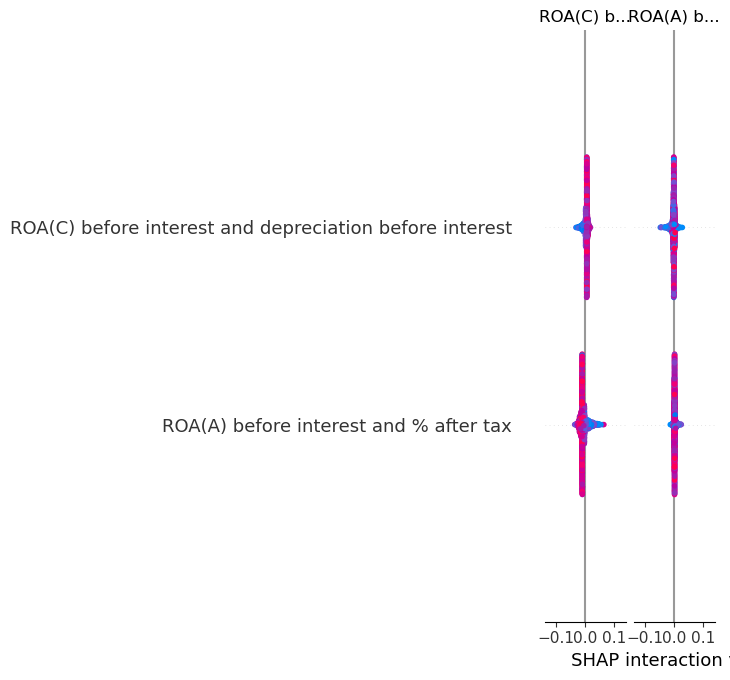

In [55]:
# Utwórz explainer SHAP dla modelu RandomForestClassifier
explainer_rf = shap.TreeExplainer(clf_rf)

# Wyjaśnij prognozy dla konkretnych przypadków testowych
shap_values_rf = explainer_rf.shap_values(X_test)

# Wizualizacja summary plot
shap.summary_plot(shap_values_rf, X_test)

### 3.4. C-Support Vector Classification

Najpierw definiujemy model C-Support Vector Classification z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [56]:
clf_svc = SVC(kernel='linear', C=1, random_state=42, probability=True)
clf_svc.fit(X_train, Y_train)

SVC(C=1, kernel='linear', probability=True, random_state=42)

Sprawdzamy, jak model przewidzi responder dla danych testowych:

In [57]:
Y_pred_svc = clf_svc.predict(X_test)

Sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [58]:
f1_svc = f1_score(Y_test, Y_pred_svc, average="weighted")
print("SVC - f1 score:", f1_svc)

SVC - f1 score: 0.9589779957071525


In [59]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_svc = clf_svc.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_svc = roc_auc_score(Y_test, Y_prob_svc)

print("ROC-AUC score:", roc_auc_svc)

ROC-AUC score: 0.9194648524486683


Teraz dostrajanie parametrów:

In [60]:
# Definicja modelu Support Vector Classifier
clf_svc = SVC()

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_svc, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


Najlepsze parametry: {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}


Wytrenujmy model z dobranymi najlepszymi parametrami:

In [62]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid'}
clf_svc = SVC(C=1, gamma='auto', kernel='sigmoid', probability=True)
clf_svc.fit(X_train, Y_train)

SVC(C=1, gamma='auto', kernel='sigmoid', probability=True)

In [63]:
Y_pred_svc = clf_svc.predict(X_test)

In [64]:
f1_svc = f1_score(Y_test, Y_pred_svc, average="weighted")
print("SVC - f1 score:", f1_svc)

SVC - f1 score: 0.9594972067039106


In [65]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_svc = clf_svc.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_svc = roc_auc_score(Y_test, Y_prob_svc)

print("SVC - ROC-AUC score:", roc_auc_svc)

SVC - ROC-AUC score: 0.7333730777997931


Sprawdźmy, co pokaże pakiet SHAP:

In [121]:
# # Tworzenie kalibrowanego modelu SVC
# calibrated_svc = CalibratedClassifierCV(base_estimator=clf_svc, cv="prefit")
# calibrated_svc.fit(X_train, Y_train)

# # Tworzenie explainera SHAP
# explainer_svc = shap.Explainer(calibrated_svc, X_train)

# # Obliczanie wartości SHAP dla danych testowych
# shap_values_svc = explainer_svc(X_test)

# # Wyświetlanie wykresu SHAP summary plot
# shap.summary_plot(shap_values_svc, X_test)

### 3.5. Gradient boosting classifier

Najpierw definiujemy model Gradient boosting classifier z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [66]:
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_gb.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

Sprawdzamy, jak model przewidzi responder dla danych testowych:

In [67]:
Y_pred_gb = clf_gb.predict(X_test)

Sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [68]:
f1_gb = f1_score(Y_test, Y_pred_gb, average="weighted")
print("Gradient boosting classifier - f1 score:", f1_gb)

Gradient boosting classifier - f1 score: 0.9562126074725622


In [69]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_gb = clf_gb.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_gb = roc_auc_score(Y_test, Y_prob_gb)

print("Gradient boosting classifier - ROC-AUC score:", roc_auc_gb)

Gradient boosting classifier - ROC-AUC score: 0.22705195420034716


Dostrajanie parametrów:

In [70]:
# Definicja modelu GradientBoostingClassifier
clf_gb = GradientBoostingClassifier()

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_gb, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


Wytrenujmy model z dobranymi najlepszymi parametrami:

In [13]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
clf_gb =  GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=300)
clf_gb.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=300)

In [72]:
Y_pred_gb = clf_gb.predict(X_test)

In [73]:
f1_gb = f1_score(Y_test, Y_pred_gb, average="weighted")
print("Gradient boosting classifier - f1 score:", f1_gb)

Gradient boosting classifier - f1 score: 0.9561804575994357


In [74]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_gb = clf_gb.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_gb = roc_auc_score(Y_test, Y_prob_gb)

print("Gradient boosting classifier - ROC-AUC score:", roc_auc_gb)

Gradient boosting classifier - ROC-AUC score: 0.9305816135084427


### 3.6. Naive Bayes

Najpierw definiujemy model Naive Bayes z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [75]:
clf_nb = GaussianNB()
clf_nb.fit(X_train, Y_train)

GaussianNB()

Sprawdzamy, jak model przewidzi responder dla danych testowych:

In [76]:
Y_pred_nb = clf_nb.predict(X_test)

Sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [77]:
f1_nb = f1_score(Y_test, Y_pred_nb, average="weighted")
print("Naive Bayes - f1 score:", f1_nb)

Naive Bayes - f1 score: 0.9560364458683884


In [78]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_nb = clf_nb.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_nb = roc_auc_score(Y_test, Y_prob_nb)

print("Naive Bayes - ROC-AUC score:", roc_auc_nb)

Naive Bayes - ROC-AUC score: 0.9302221598779612


Dostrajanie parametrów:

In [79]:
# Definicja modelu
clf_nb = GaussianNB()

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'priors': [None, [0.1, 0.9], [0.5, 0.5], [0.9, 0.1]]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_nb, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


Najlepsze parametry: {'priors': [0.9, 0.1]}


Wytrenujmy model z dobranymi najlepszymi parametrami:

In [80]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'priors': [0.9, 0.1]}
clf_nb =  GaussianNB(priors=[0.9, 0.1])
clf_nb.fit(X_train, Y_train)

GaussianNB(priors=[0.9, 0.1])

In [86]:
Y_pred_nb = clf_nb.predict(X_test)

In [87]:
f1_nb = f1_score(Y_test, Y_pred_nb, average="weighted")
print("Naive Bayes - f1 score:", f1_nb)

Naive Bayes - f1 score: 0.9539893389492238


In [88]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_nb = clf_nb.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_nb = roc_auc_score(Y_test, Y_prob_nb)

print("Naive Bayes - ROC-AUC score:", roc_auc_nb)

Naive Bayes - ROC-AUC score: 0.9301257210990515


Z uwagi na specifykę modelu Naive Bayes praca z pakietem SHAP w tym wypadku nie ma sensu.

### 3.7. KNN

Najpierw definiujemy model KNN z przykładowymi parametrami i dopasowujemy do danych treningowych.

In [81]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, Y_train)

KNeighborsClassifier()

Sprawdzamy, jak model przewidzi responder dla danych testowych:

In [82]:
Y_pred_knn = clf_knn.predict(X_test)

Sprawdzamy wskaźniki f1 oraz ROC_AUC:

In [83]:
f1_knn = f1_score(Y_test, Y_pred_knn, average="weighted")
print("KNN - f1 score:", f1_knn)

KNN - f1 score: 0.9637279720642699


In [84]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_knn = clf_knn.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_knn = roc_auc_score(Y_test, Y_prob_knn)

print("KNN - ROC-AUC score:", roc_auc_knn)

KNN - ROC-AUC score: 0.8060353141274045


Dostrajanie parametrów:

In [85]:
# Definicja modelu
clf_knn = KNeighborsClassifier()

# Definicja siatki wartości parametrów do przeszukania
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'leaf_size': [20, 30, 40]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(clf_knn, param_grid, cv=5, scoring='f1')

# Dopasowanie modelu do danych treningowych
grid_search.fit(X_train, Y_train)

# Najlepsze znalezione parametry
print("Najlepsze parametry:", grid_search.best_params_)


Najlepsze parametry: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


Wytrenujmy model z dobranymi najlepszymi parametrami:

In [89]:
# otrzymane najlepsze parametry:
# Najlepsze parametry: {'algorithm': 'auto', 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
clf_knn = KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='euclidean', n_neighbors=3, weights='uniform')
clf_knn.fit(X_train, Y_train)

KNeighborsClassifier(leaf_size=20, metric='euclidean', n_neighbors=3)

In [90]:
Y_pred_knn = clf_knn.predict(X_test)

In [91]:
f1_knn = f1_score(Y_test, Y_pred_knn, average="weighted")
print("KNN - f1 score:", f1_knn)

KNN - f1 score: 0.9590054702048417


In [92]:
# Przewidywanie prawdopodobieństw dla klas pozytywnej (1) z modelu
Y_prob_knn = clf_knn.predict_proba(X_test)[:, 1]

# Obliczanie wskaźnika ROC-AUC
roc_auc_knn = roc_auc_score(Y_test, Y_prob_knn)

print("KNN - ROC-AUC score:", roc_auc_knn)

KNN - ROC-AUC score: 0.7986007609896373


Sprawdźmy jeszcze, co pokaże SHAP:

In [11]:
# tu coś za długo mielił - chyba skip
# # Redukcja próbek danych tła
# background_summary = shap.sample(X_train, 100)  # Możesz dostosować liczbę próbek

# # Tworzenie explainera SHAP
# explainer_knn = shap.KernelExplainer(clf_knn.predict_proba, X_train)

# # Obliczanie wartości SHAP dla danych testowych
# shap_values_knn = explainer_knn.shap_values(X_test)

# # Wizualizacja wyników
# shap.summary_plot(shap_values_knn, X_test)

## 4. Podsumowanie działania modeli

Porównamy wskaźniki f1 score i ROC-AUC dla sprawdzonych modeli:

In [93]:
# Definicja modeli do porównania
models = ["Logistic Regression", "Decision Tree - GINI", "Decision Tree - Entropy", "Random Forest", "SVC", "Gradient Boosting", "Naive Bayes", "KNN"]

# Lista wyników f1:
f1_scores = [f1_lr, f1_dt, f1_dte, f1_rf, f1_svc, f1_gb, f1_nb, f1_knn]

# Lista wyników ROC-AUC:
ROC_AUC_scores = [roc_auc_lr, roc_auc_dt, roc_auc_dte, roc_auc_rf, roc_auc_svc, roc_auc_gb, roc_auc_nb, roc_auc_knn]

data = {
    "Model": models,
    "F1 Score": f1_scores,
    "ROC-AUC Score": ROC_AUC_scores
}

result = pd.DataFrame(data)
print(result)


                     Model  F1 Score  ROC-AUC Score
0      Logistic Regression  0.964717       0.941032
1     Decision Tree - GINI  0.949470       0.682997
2  Decision Tree - Entropy  0.934999       0.704073
3            Random Forest  0.962811       0.933422
4                      SVC  0.959497       0.733373
5        Gradient Boosting  0.956180       0.930582
6              Naive Bayes  0.953989       0.930126
7                      KNN  0.959005       0.798601


Ranking po f1 score:

In [94]:
# Sortowanie ramki danych po wartościach w kolumnie 'F1 Score' (malejąco)
ranking_f1 = result.sort_values(by='F1 Score', ascending=False)

# Wyświetlenie posortowanej ramki danych
print(ranking_f1[['Model', 'F1 Score']])


                     Model  F1 Score
0      Logistic Regression  0.964717
3            Random Forest  0.962811
4                      SVC  0.959497
7                      KNN  0.959005
5        Gradient Boosting  0.956180
6              Naive Bayes  0.953989
1     Decision Tree - GINI  0.949470
2  Decision Tree - Entropy  0.934999


Ranking po ROC-AUC:

In [95]:
# Sortowanie ramki danych po wartościach w kolumnie 'ROC-AUC Score' (malejąco)
ranking_rocauc = result.sort_values(by='ROC-AUC Score', ascending=False)

# Wyświetlenie posortowanej ramki danych
print(ranking_rocauc[['Model', 'ROC-AUC Score']])


                     Model  ROC-AUC Score
0      Logistic Regression       0.941032
3            Random Forest       0.933422
5        Gradient Boosting       0.930582
6              Naive Bayes       0.930126
7                      KNN       0.798601
4                      SVC       0.733373
2  Decision Tree - Entropy       0.704073
1     Decision Tree - GINI       0.682997


## 5. Wykresy dodatkowe do prezentacji

Zobaczmy jeszcze jak otrzymane wyniki prezentują się na wykresach.

Text(0.5, 1.0, 'Krzywe ROC')

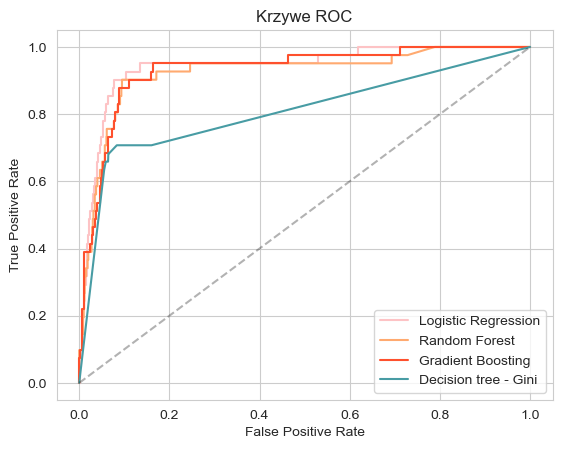

In [35]:
y_predict = clf_lr.predict_proba(X_test)[:,1]
y_predict2 = clf_rf.predict_proba(X_test)[:,1]
y_predict3 = clf_gb.predict_proba(X_test)[:,1]
y_predict4 = clf_dt.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict)
plt.plot(fpr, tpr, color='#FDC3C5', label='Logistic Regression')
fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict2)
plt.plot(fpr, tpr, color='#FFAA70', label='Random Forest')
fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict3)
plt.plot(fpr, tpr, color='#FE502D', label='Gradient Boosting')
fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict4)
plt.plot(fpr, tpr, color='#489CA4', label='Decision tree - Gini')
plt.plot([0, 1], [0,1], '--', color='black', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Krzywe ROC')

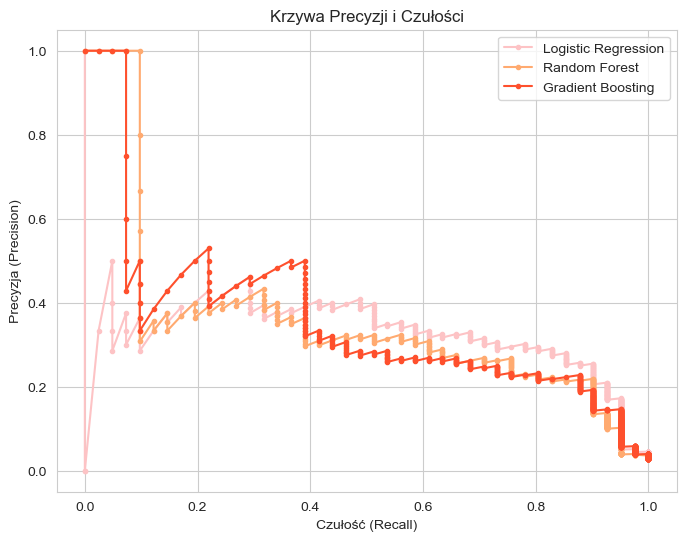

In [38]:

plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(Y_test, y_predict)
plt.plot(recall, precision, marker='.', color='#FDC3C5', label='Logistic Regression')
precision, recall, _ = precision_recall_curve(Y_test, y_predict2)
plt.plot(recall, precision, marker='.', color='#FFAA70', label='Random Forest')
precision, recall, _ = precision_recall_curve(Y_test, y_predict3)
plt.plot(recall, precision, marker='.', color='#FE502D', label='Gradient Boosting')
plt.xlabel('Czułość (Recall)')
plt.ylabel('Precyzja (Precision)')
plt.title('Krzywa Precyzji i Czułości')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
y_pred = clf_lr.predict(X_test)
y_pred2 = clf_rf.predict(X_test)
y_pred3 = clf_gb.predict(X_test)
metrics.confusion_matrix(Y_test, y_pred)

array([[1371,   20],
       [  28,   13]], dtype=int64)

In [43]:
metrics.confusion_matrix(Y_test, y_pred2)

array([[1378,   13],
       [  33,    8]], dtype=int64)

In [44]:
metrics.confusion_matrix(Y_test, y_pred3)

array([[1342,   49],
       [  22,   19]], dtype=int64)

## 6. Dodatkowy test dla Logistic Regression

Dla 12 najbardziej znaczących cech wytrenujmy ponownie model Logistic Regression żeby sprawdzić, czy możemy jeszcze zmniejszyć liczbę zmiennych:

In [59]:
beta = pd.DataFrame(clf_lr.coef_, columns=X_train.columns)

In [60]:
beta = beta.T
beta.columns = ['value']
beta['abs'] = beta['value'].abs()

In [90]:
beta_sorted = beta.sort_values(by='abs', ascending=False)
beta_sorted = beta_sorted.head(12)
beta_sorted

,value,abs
Net Value Per Share (B),-4.205376,4.205376
Net Value Per Share (C),3.609312,3.609312
Liability to Equity,-2.494913,2.494913
Borrowing dependency,2.379048,2.379048
our_CashFlow_to_Debt_Ratio,-1.754314,1.754314
Persistent EPS in the Last Four Seasons,-1.724468,1.724468
Regular Net Profit Growth Rate,1.620192,1.620192
After-tax Net Profit Growth Rate,-1.618277,1.618277
Per Share Net profit before tax (Yuan ¥),1.498484,1.498484
Net profit before tax/Paid-in capital,-0.919322,0.919322


Zdefiniujmy nowe ramki danych zawierające tylko wybrane powyżej wskaźniki:

In [91]:
X_test_new = X_test[list(beta_sorted.index)]
X_train_new = X_train[list(beta_sorted.index)]
X_test_new

,Net Value Per Share (B),Net Value Per Share (C),Liability to Equity,Borrowing dependency,our_CashFlow_to_Debt_Ratio,Persistent EPS in the Last Four Seasons,Regular Net Profit Growth Rate,After-tax Net Profit Growth Rate,Per Share Net profit before tax (Yuan ¥),Net profit before tax/Paid-in capital,Working Capital/Equity,ROA(B) before interest and depreciation after tax
0,0.192116,0.191807,-0.394375,-0.310492,1.493557,-0.405890,0.017044,0.019599,-0.397634,-0.428214,-0.136925,-0.393334
1,0.363630,0.363183,-0.173188,-0.022980,-0.198408,0.415046,0.033714,0.036378,0.223281,0.227277,-0.549708,1.061499
2,-0.499063,-0.498809,0.354708,0.405163,-0.575536,-0.097311,0.157149,0.160621,-0.083931,-0.140045,0.120388,0.248659
3,1.344079,1.342835,-0.348013,-0.315384,0.835165,0.531491,0.069305,0.072202,0.565109,0.647286,0.704091,0.469702
4,-0.225151,-0.225120,-0.107229,-0.038130,-0.325475,0.129756,0.039081,0.041354,0.043714,0.054871,-0.306009,0.482912
...,...,...,...,...,...,...,...,...,...,...,...,...
1427,3.783682,3.780454,-0.439108,-0.315384,4.256112,1.433937,0.035152,0.037826,0.948043,1.102667,0.303241,0.893295
1428,-0.276350,-0.276277,-0.228951,-0.154439,-0.087454,-0.280711,0.157708,0.161184,-0.287297,-0.301073,-0.469442,-0.262998
1429,-0.394106,-0.393937,-0.279615,-0.135689,0.072596,0.103556,0.030561,0.033204,0.039387,0.071938,0.613105,0.487315
1430,-0.451704,-0.451489,-0.265313,-0.315384,0.022118,-0.143889,0.023195,0.025790,-0.161816,-0.156123,0.907006,-0.019058


Jeszcze raz trenujemy model Logistic Regression:

In [92]:
clf_lr_new = LogisticRegression(penalty='l2',  C=10.0, solver='newton-cg', max_iter=100)
clf_lr_new.fit(X_train_new, Y_train)

LogisticRegression(C=10.0, solver='newton-cg')

Zobaczmy, jak wyglądają krzywe ROC:

Text(0.5, 1.0, 'Krzywe ROC')

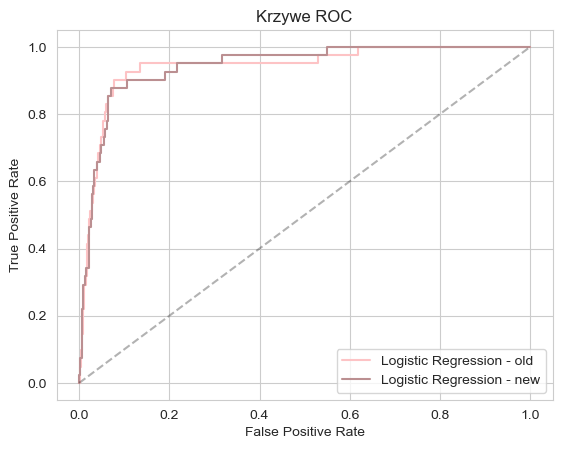

In [93]:
y_predict = clf_lr.predict_proba(X_test)[:,1]
y_predict_new = clf_lr_new.predict_proba(X_test_new)[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict)
plt.plot(fpr, tpr, color='#FDC3C5', label='Logistic Regression - old')
fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict_new)
plt.plot(fpr, tpr, color='#bb8f91', label='Logistic Regression - new')
plt.plot([0, 1], [0,1], '--', color='black', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Krzywe ROC')

In [95]:
roc_auc = roc_auc_score(Y_test, y_predict)
roc_auc_new = roc_auc_score(Y_test, y_predict_new)
roc_auc, roc_auc_new

(0.9410320702775683, 0.9425400220932475)

Wytrenujmy teraz ponownie model Random Forest, żeby zweryfikować, czy po ograniczeniu liczby zmiennych model się nie psuje:

In [99]:
clf_rf_new = RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=100)
clf_rf_new.fit(X_train_new, Y_train)

RandomForestClassifier(min_samples_split=5)

Sprawdźmy, jak wyglądają krzywe ROC:

Text(0.5, 1.0, 'Krzywe ROC')

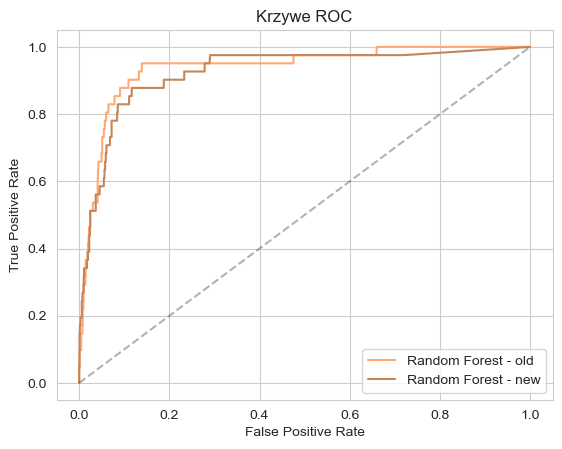

In [102]:
y_predict = clf_lr.predict_proba(X_test)[:,1]
y_predict_new = clf_lr_new.predict_proba(X_test_new)[:,1]
y_predict2 = clf_rf.predict_proba(X_test)[:,1]
y_predict2_new = clf_rf_new.predict_proba(X_test_new)[:,1]

# fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict)
# plt.plot(fpr, tpr, color='#FDC3C5', label='Logistic Regression - old')
# fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict_new)
# plt.plot(fpr, tpr, color='#bb8f91', label='Logistic Regression - new')
fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict2)
plt.plot(fpr, tpr, color='#FFAA70', label='Random Forest - old')
fpr, tpr, _ = metrics.roc_curve(Y_test, y_predict2_new)
plt.plot(fpr, tpr, color='#c68457', label='Random Forest - new')
plt.plot([0, 1], [0,1], '--', color='black', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Krzywe ROC')

Widzimy, że wskaźniki nadal są dobre - zmniejszenie liczby wskaźników do 12 nie wpłynęło negatywnie na model.

In [103]:
X_train_new.columns.tolist()

['Net Value Per Share (B)',
 'Net Value Per Share (C)',
 'Liability to Equity',
 'Borrowing dependency',
 'our_CashFlow_to_Debt_Ratio',
 'Persistent EPS in the Last Four Seasons',
 'Regular Net Profit Growth Rate',
 'After-tax Net Profit Growth Rate',
 'Per Share Net profit before tax (Yuan ¥)',
 'Net profit before tax/Paid-in capital',
 'Working Capital/Equity',
 'ROA(B) before interest and depreciation after tax']

Obliczmy wartości Shapleya dla każdej z 12 cech i zobaczmy, jaki mają wpływ na model:

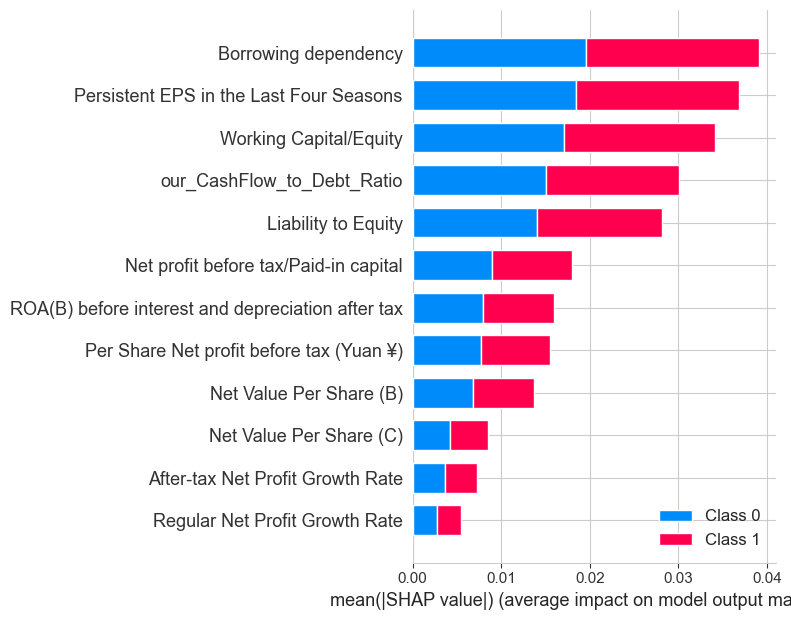

In [110]:
explainer_rf_new = shap.TreeExplainer(clf_rf_new)
shap_values_rf_new = explainer_rf_new.shap_values(X_test_new)
colors = ["#FFAA70", "#FE502D"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
plt.figure()
shap.summary_plot(shap_values_rf_new, X_test_new, show=False)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)
plt.show()
# shap.summary_plot(shap_values_rf_new, X_test_new, plot_cmap=cmap)

Wygenerujmy jeszcze raporty metryki oceny wydajności dla obu modeli.

Random Forest:

In [111]:
from sklearn.metrics import classification_report

print(classification_report(clf_rf_new.predict(X_test_new), Y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1417
           1       0.20      0.53      0.29        15

    accuracy                           0.97      1432
   macro avg       0.60      0.76      0.64      1432
weighted avg       0.99      0.97      0.98      1432


Logistic Regression:

In [112]:
print(classification_report(clf_lr_new.predict(X_test_new), Y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1394
           1       0.34      0.37      0.35        38

    accuracy                           0.96      1432
   macro avg       0.66      0.67      0.67      1432
weighted avg       0.97      0.96      0.97      1432


In [114]:
roc_auc = roc_auc_score(Y_test, clf_lr_new.predict_proba(X_test_new)[:,1])
roc_auc_new = roc_auc_score(Y_test, clf_rf_new.predict_proba(X_test_new)[:,1])
roc_auc, roc_auc_new

(0.9425400220932475, 0.9250320001402746)

## 7. Wnioski

Podsumujmy wyniki uzyskane na tym etapie projektu:
* Spośród ramek danych z 13 i z 27 cechami, dane z 27 cechami otrzymywały lepsze wyniki, dlatego to one zostały wybrane do dalszej pracy.
* Porównywane zostały wskaźniki f1-score i ROC-AUC dla wszystkich modeli.
* Według wskaźnika f1 score najlepiej wypadły modele Logistic Regression, Random Forest i SVC.
* Według wskaźnika ROC-AUC najlepiej wypadły modele Logistic Regression, Random Forest i Gradient Boosting.
* Dodatkowy test wykazał, że zmniejszenie liczby wskaźników do 12 nie wpłynie negatywnie na modelowanie.
* Najlepszym modelem, który został ostatecznie wybrany przez zespół deweloperski, okazał się model Logistic Regression bazujący na 12 najlepszych wskaźnikach.